# Lake model

see also [this general introduction to the workbench](https://waterprogramming.wordpress.com/2017/11/01/using-the-exploratory-modelling-workbench/) as a source of inspiration for completing the assignment below

## the lake model
The exploratory modeling workbench includes an example folder. This folder contains a variety of examples that demonstrate the functionality of the workbench. Many of these examples have been drawn from published cases. Here, we use the Lake Problem as an example for demonstrating some of the key functionality of the workbench. 

We demonstrate some of the key capabilities of the exploratory modeling workbench using the Lake problem. The lake problem is a stylized and hypothetical decision problem where the population of a city has to decide on the amount of annual pollution it will put into a lake. It the pollution in the lake passes a threshold, it will suffer irreversible eutrophication. 

\begin{equation}
    X_{(t+1)}=X_t+a_t+\frac{(X_t^q)}{(1+X_t^q )}- bX_t+\epsilon_t
\end{equation}

where $X_t$ is the pollution at time $t$, $a_t$ is the rate of anthropogenic pollution at time $t$, $b$ is the lake’s natural removal rate, $q$ is the lake's natural recycling rate, $\epsilon_t$ is the rate of natural pollution at time $t$. The rate of anthropogenic pollution $a_t$ is the decision variable and is somewhere between 0, and 0.1. So $a_t \in [0,0.1]$. The natural pollution $\epsilon_t$ is modeled, following Singh et al. (2015), as a log normal distribution with mean $\mu$ and standard deviation $\sigma$. 
There are four outcomes of interest. The first is the average concentration of phosphor in the lake. 

\begin{equation}
    f_{phosphorus}=  \frac{1}{\left\vert{T}\right\vert} \sum\limits_{t\in{T}} X_t 
\end{equation}

where $\left\vert{T}\right\vert$ is the cardinality of the set of points in time. 
The second objective is the economic benefit derived from polluting the lake. Following Singh et al. (2015), this is defined as the discounted benefit of pollution mines the costs of having a polluted lake

\begin{equation}
    f_{economic} = \sum\limits_{t \in {T}}\alpha a_t \delta^t 
\end{equation}

where $\alpha$ is the utility derived from polluting and $\delta$ is the discount rate. By default, $\alpha$ is 0.04.
The third objective is related to the year over year change in the anthropogenic pollution rate. 

\begin{equation}
    f_{inertia} =\frac{1}{\left\vert{T}\right\vert-1} \sum\limits_{t=1}^{\left\vert{T}\right\vert} I(|a_{t}-a_{t-1} |>\tau)   
\end{equation}

where $I$ is an indicator function that is 0 if the statement is false, and 1 if the statement is true, $\tau$ is the threshold that is deemed undesirable, and is for illustrative purposes et to 0.2. Effectively, f_{inertia} is the fraction of years where the absolute value of the change in anthropogenic pollution is larger then $\tau$.
The fourth objective is the fraction of years where the pollution in the lake is below the critical threshold.

\begin{equation}
    f_{reliability} =  \frac{1}{\left\vert{T}\right\vert} \sum\limits_{t \in T}I(X_{t}<X_{crit} ) 
\end{equation}

where $I$ is an indicator function that is 0 if the statement is false, and 1 if the statement is true, $X_{crit}$ is the critical threshold of pollution and is a function of both $b$ and $q$.

The lake problem is characterized by both stochastic uncertainty and deep uncertainty. The stochastic uncertainty arises from the natural inflow. To reduce this stochastic uncertainty, multiple replications are performed and the average over the replication is taken. Deep uncertainty is presented by uncertainty about the mean $\mu$ and standard deviation $sigma$ of the lognormal distribution characterizing the natural inflow, the natural removal rate of the lake $\beta$, the natural recycling rate of the lake $q$, and the discount rate $\delta$. The table below specifies the ranges for the deeply uncertain factors, as well as their best estimate or default values. 


## Assignment
1. Given the Python implementation of the lake problem in lakemodel_function.py, adapt this code and connect it to the workbench

for the uncertainties, use the following table

|Parameter	|Range	        |Default value|
|-----------|--------------:|------------:|
|$\mu$    	|0.01 – 0.05	|0.02         |
|$\sigma$	|0.001 – 0.005 	|0.0017       |
|$b$      	|0.1 – 0.45	    |0.42         |
|$q$	    |2 – 4.5	    |2            |
|$\delta$	|0.93 – 0.99	|0.98         |

For now, assume that for each year a release decision is made. The release is between 0 and 0.1. Carefully look at line 23 in lake_model.py to identify the name to use for each lever.




In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brentq
import importlib
import os
os.system("lake_problem_nesya.py")
from lake_problem_nesya import lake_problem
from ema_workbench import Model, RealParameter, TimeSeriesOutcome, ArrayOutcome, ScalarOutcome, SequentialEvaluator
from ema_workbench.analysis import pairs_plotting, prim
from ema_workbench import (MultiprocessingEvaluator, ema_logging,
                           perform_experiments)
ema_logging.log_to_stderr(ema_logging.INFO)
import pandas as pd
import ipyparallel as ipp
import time
from ema_workbench import IpyparallelEvaluator, MultiprocessingEvaluator

In [60]:
#max_P is the maximum level of daily average pollution at the lake (X): to be lowered
#utility is the economic benefit derived from polluting the lake (f-economic): to be increased
#inertia is the fraction of years where the absolute value of the change in anthropogenic pollution is
#undesirable (f-inertia): : to be lowered
#reliability is the fraction of years where the pollution in the lake is below the critical threshold (f-reliability)
#:to be increased

In [2]:
model = Model('LakeProblem', function=lake_problem)
model.uncertainties = [RealParameter('b', 0.1, 0.45), RealParameter('mean', 0.01, 0.05),
                       RealParameter('stdev', 0.001, 0.005), RealParameter('delta', 0.93, 0.99),
                       RealParameter('q', 2, 4.5)]
model.levers =  [RealParameter('l0', 0.0, 0.1),RealParameter('l36', 0.0, 0.1),RealParameter('l72', 0.0, 0.1),
                     RealParameter('l1', 0.0, 0.1),RealParameter('l37', 0.0, 0.1),RealParameter('l73', 0.0, 0.1),
                     RealParameter('l2', 0.0, 0.1),RealParameter('l38', 0.0, 0.1),RealParameter('l74', 0.0, 0.1),
                     RealParameter('l3', 0.0, 0.1),RealParameter('l39', 0.0, 0.1),RealParameter('l75', 0.0, 0.1),
                     RealParameter('l4', 0.0, 0.1),RealParameter('l40', 0.0, 0.1),RealParameter('l76', 0.0, 0.1),
                     RealParameter('l5', 0.0, 0.1),RealParameter('l41', 0.0, 0.1),RealParameter('l77', 0.0, 0.1),
                       RealParameter('l6', 0.0, 0.1),RealParameter('l42', 0.0, 0.1),RealParameter('l78', 0.0, 0.1),
                       RealParameter('l7', 0.0, 0.1),RealParameter('l43', 0.0, 0.1),RealParameter('l79', 0.0, 0.1),
                       RealParameter('l8', 0.0, 0.1),RealParameter('l44', 0.0, 0.1),RealParameter('l80', 0.0, 0.1),
                       RealParameter('l9', 0.0, 0.1),RealParameter('l45', 0.0, 0.1),RealParameter('l81', 0.0, 0.1),
                       RealParameter('l10', 0.0, 0.1),RealParameter('l46', 0.0, 0.1),RealParameter('l82', 0.0, 0.1),
                       RealParameter('l11', 0.0, 0.1),RealParameter('l47', 0.0, 0.1),RealParameter('l83', 0.0, 0.1),
                       RealParameter('l12', 0.0, 0.1),RealParameter('l48', 0.0, 0.1),RealParameter('l84', 0.0, 0.1),
                       RealParameter('l13', 0.0, 0.1),RealParameter('l49', 0.0, 0.1),RealParameter('l85', 0.0, 0.1),
                       RealParameter('l14', 0.0, 0.1),RealParameter('l50', 0.0, 0.1),RealParameter('l86', 0.0, 0.1),
                       RealParameter('l15', 0.0, 0.1),RealParameter('l51', 0.0, 0.1),RealParameter('l87', 0.0, 0.1),
                       RealParameter('l16', 0.0, 0.1),RealParameter('l52', 0.0, 0.1),RealParameter('l88', 0.0, 0.1),
                       RealParameter('l17', 0.0, 0.1),RealParameter('l53', 0.0, 0.1),RealParameter('l89', 0.0, 0.1),
                       RealParameter('l18', 0.0, 0.1),RealParameter('l54', 0.0, 0.1),RealParameter('l90', 0.0, 0.1),
                       RealParameter('l19', 0.0, 0.1),RealParameter('l55', 0.0, 0.1),RealParameter('l91', 0.0, 0.1),
                       RealParameter('l20', 0.0, 0.1),RealParameter('l56', 0.0, 0.1),RealParameter('l92', 0.0, 0.1),
                       RealParameter('l21', 0.0, 0.1),RealParameter('l57', 0.0, 0.1),RealParameter('l93', 0.0, 0.1),
                       RealParameter('l22', 0.0, 0.1),RealParameter('l58', 0.0, 0.1),RealParameter('l94', 0.0, 0.1),
                       RealParameter('l23', 0.0, 0.1),RealParameter('l59', 0.0, 0.1),RealParameter('l95', 0.0, 0.1),
                       RealParameter('l24', 0.0, 0.1),RealParameter('l60', 0.0, 0.1),RealParameter('l96', 0.0, 0.1),
                       RealParameter('l25', 0.0, 0.1),RealParameter('l61', 0.0, 0.1),RealParameter('l97', 0.0, 0.1),
                       RealParameter('l26', 0.0, 0.1),RealParameter('l62', 0.0, 0.1),RealParameter('l98', 0.0, 0.1),
                       RealParameter('l27', 0.0, 0.1),RealParameter('l63', 0.0, 0.1),RealParameter('l99', 0.0, 0.1),
                       RealParameter('l28', 0.0, 0.1),RealParameter('l64', 0.0, 0.1),
                       RealParameter('l29', 0.0, 0.1),RealParameter('l65', 0.0, 0.1),
                       RealParameter('l30', 0.0, 0.1),RealParameter('l66', 0.0, 0.1),
                       RealParameter('l31', 0.0, 0.1),RealParameter('l67', 0.0, 0.1),
                       RealParameter('l32', 0.0, 0.1),RealParameter('l68', 0.0, 0.1),
                       RealParameter('l33', 0.0, 0.1),RealParameter('l69', 0.0, 0.1),
                       RealParameter('l34', 0.0, 0.1),RealParameter('l70', 0.0, 0.1),
                       RealParameter('l35', 0.0, 0.1),RealParameter('l71', 0.0, 0.1)] 

model.outcomes = [ScalarOutcome('max_P'), ScalarOutcome('utility'), ScalarOutcome('inertia'), ScalarOutcome('reliability')]

2. Explore the behavior of the system in the absence of any release using 1000 scenarios, and the default sampling approach.
    * visualize the outcomes of interest, are there any apparent trade-offs?
    * can you visually identify the uncertainties that drive system behavior?


In [3]:
with SequentialEvaluator(model) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(scenarios=1000, policies=1)

[MainProcess/INFO] performing 1000 scenarios * 1 policies * 1 model(s) = 1000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] experiments finished


In [4]:
experiments

,b,delta,mean,q,stdev,l0,l1,l10,l11,l12,...,l93,l94,l95,l96,l97,l98,l99,scenario,policy,model
0,0.172167,0.932409,0.017231,3.706254,0.004009,0.066244,0.012867,0.047502,0.087907,0.050053,...,0.05496,0.030806,0.053667,0.073743,0.086401,0.011367,0.042209,0,0,LakeProblem
1,0.347733,0.941763,0.041252,2.127898,0.002595,0.066244,0.012867,0.047502,0.087907,0.050053,...,0.05496,0.030806,0.053667,0.073743,0.086401,0.011367,0.042209,1,0,LakeProblem
2,0.371060,0.932859,0.033143,2.889509,0.003469,0.066244,0.012867,0.047502,0.087907,0.050053,...,0.05496,0.030806,0.053667,0.073743,0.086401,0.011367,0.042209,2,0,LakeProblem
3,0.151690,0.944453,0.042871,3.336713,0.002301,0.066244,0.012867,0.047502,0.087907,0.050053,...,0.05496,0.030806,0.053667,0.073743,0.086401,0.011367,0.042209,3,0,LakeProblem
4,0.429405,0.988469,0.032053,2.643132,0.002279,0.066244,0.012867,0.047502,0.087907,0.050053,...,0.05496,0.030806,0.053667,0.073743,0.086401,0.011367,0.042209,4,0,LakeProblem
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.132861,0.962392,0.024921,3.285087,0.001814,0.066244,0.012867,0.047502,0.087907,0.050053,...,0.05496,0.030806,0.053667,0.073743,0.086401,0.011367,0.042209,995,0,LakeProblem
996,0.328632,0.930560,0.030342,4.074623,0.001225,0.066244,0.012867,0.047502,0.087907,0.050053,...,0.05496,0.030806,0.053667,0.073743,0.086401,0.011367,0.042209,996,0,LakeProblem
997,0.266085,0.963741,0.028140,4.100124,0.001450,0.066244,0.012867,0.047502,0.087907,0.050053,...,0.05496,0.030806,0.053667,0.073743,0.086401,0.011367,0.042209,997,0,LakeProblem
998,0.251911,0.950880,0.036778,4.409602,0.004107,0.066244,0.012867,0.047502,0.087907,0.050053,...,0.05496,0.030806,0.053667,0.073743,0.086401,0.011367,0.042209,998,0,LakeProblem


[MainProcess/INFO] no time dimension found in results


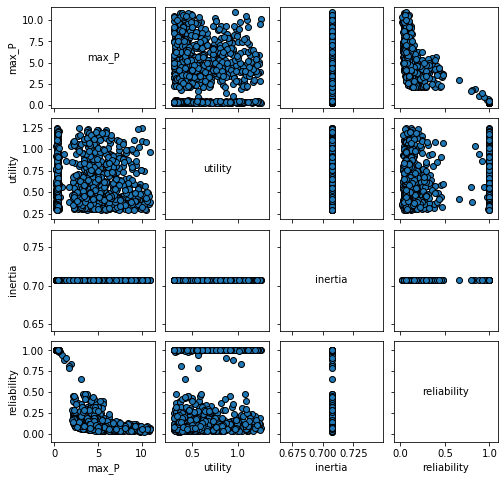

In [5]:
fig, axes = pairs_plotting.pairs_scatter(experiments, outcomes, legend=False)
fig.set_size_inches(8,8)
plt.show()

Reliability would get lowered when Max_P is higher.

In [6]:
x = experiments
y = outcomes['max_P'] <0.8
prim_alg = prim.Prim(x, y, threshold=0.8)
box1 = prim_alg.find_box()

[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] 1000 points remaining, containing 336 cases of interest
[MainProcess/INFO] mean: 0.9821428571428571, mass: 0.168, coverage: 0.49107142857142855, density: 0.9821428571428571 restricted_dimensions: 3


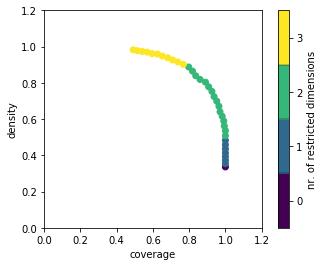

In [7]:
box1.show_tradeoff()
plt.show()

coverage    0.860119
density     0.818697
id                20
mass           0.353
mean        0.818697
res_dim            2
Name: 20, dtype: object

     box 20                                          
        min       max                       qp values
b  0.270485  0.449908  [2.2467890841171282e-45, -1.0]
q  2.780309  4.499741  [1.9894900404413574e-17, -1.0]



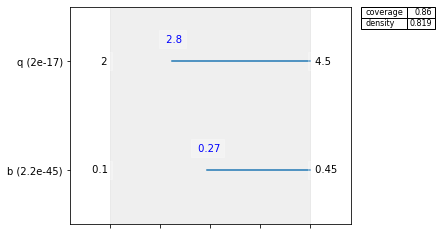

In [8]:
box1.inspect(20)
box1.inspect(20, style='graph')
plt.show()

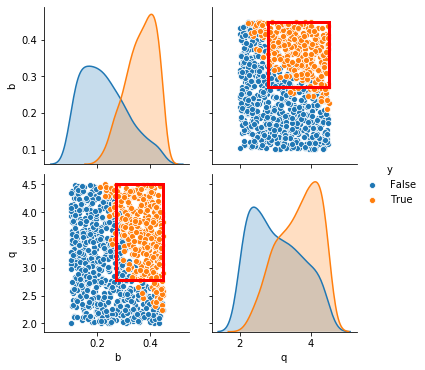

In [9]:
box1.show_pairs_scatter(20)
plt.show()

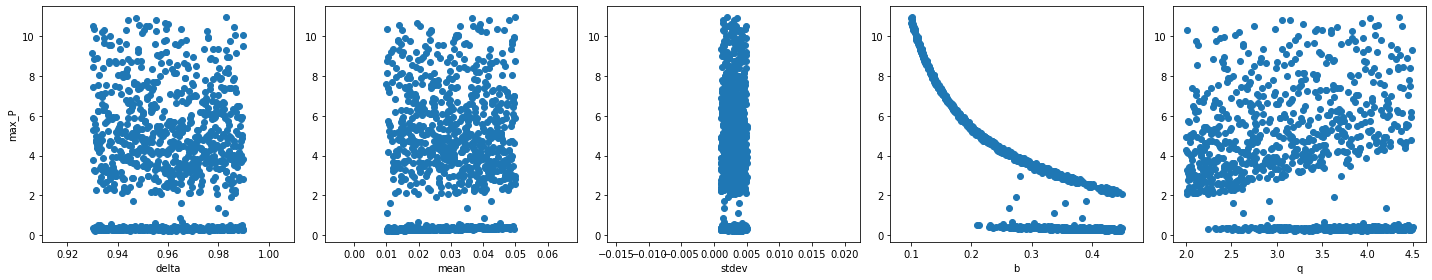

In [10]:
X = outcomes['max_P']
#maxX = np.max(X, axis=1)

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 4))
axes[0].scatter(experiments['delta'], X)
axes[1].scatter(experiments['mean'], X)
axes[2].scatter(experiments['stdev'], X)
axes[3].scatter(experiments['b'], X)
axes[4].scatter(experiments['q'], X)
axes[0].set_xlabel('delta')
axes[1].set_xlabel('mean')
axes[2].set_xlabel('stdev')
axes[3].set_xlabel('b')
axes[4].set_xlabel('q')
axes[0].set_ylabel('max_P')
fig.tight_layout()

plt.show()

3. Explore the behavior of the system over 1000 scenarios for 4 randomly sampled candidate strategies.
    * visualize the outcomes of interest
    * what can you say about how the release decision influences the system?

In [11]:
with SequentialEvaluator(model) as evaluator:
    experiments2, outcomes2 = evaluator.perform_experiments(scenarios=1000, policies=4)

[MainProcess/INFO] performing 1000 scenarios * 4 policies * 1 model(s) = 4000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3200 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] experiments finished


[MainProcess/INFO] no time dimension found in results


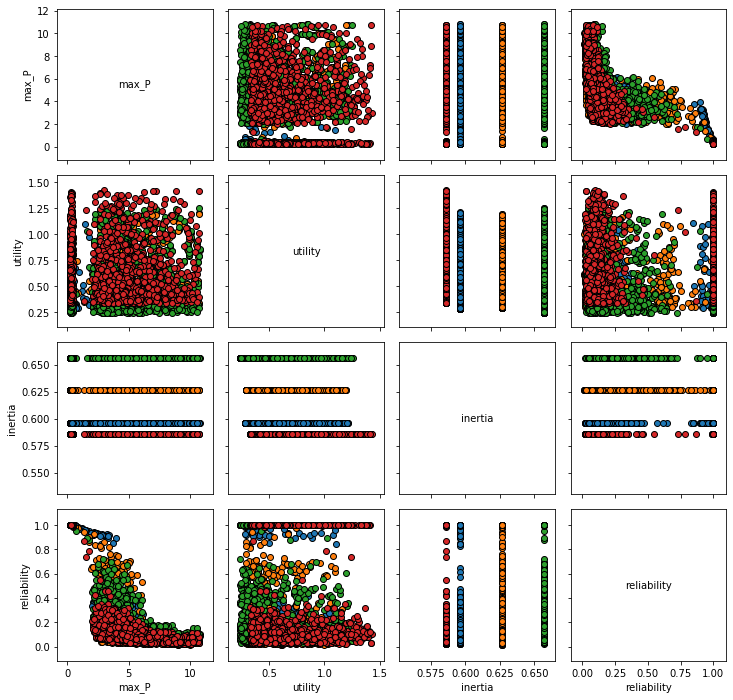

In [12]:
fig, axes2 = pairs_plotting.pairs_scatter(experiments2, outcomes2, group_by='policy', legend=False)
fig.set_size_inches(12,12)
plt.show()

In [13]:
policies = experiments2['policy']
for i, policy in enumerate(np.unique(policies)):
    experiments2.loc[policies==policy, 'policy'] = str(i)

data = pd.DataFrame(outcomes2)
data['policy'] = policies
data

,max_P,utility,inertia,reliability,policy
0,5.412783,0.315448,0.595960,0.0710,1
1,5.336826,0.335312,0.595960,0.1239,1
2,2.322241,0.445504,0.595960,0.1259,1
3,2.465312,0.771485,0.595960,0.9342,1
4,4.092606,0.352517,0.595960,0.2651,1
...,...,...,...,...,...
3995,8.245501,0.477338,0.585859,0.0400,4
3996,2.492156,0.849688,0.585859,0.3320,4
3997,7.559748,0.589439,0.585859,0.1183,4
3998,4.140545,0.340553,0.585859,0.1582,4


### Release decision's influence to max_P

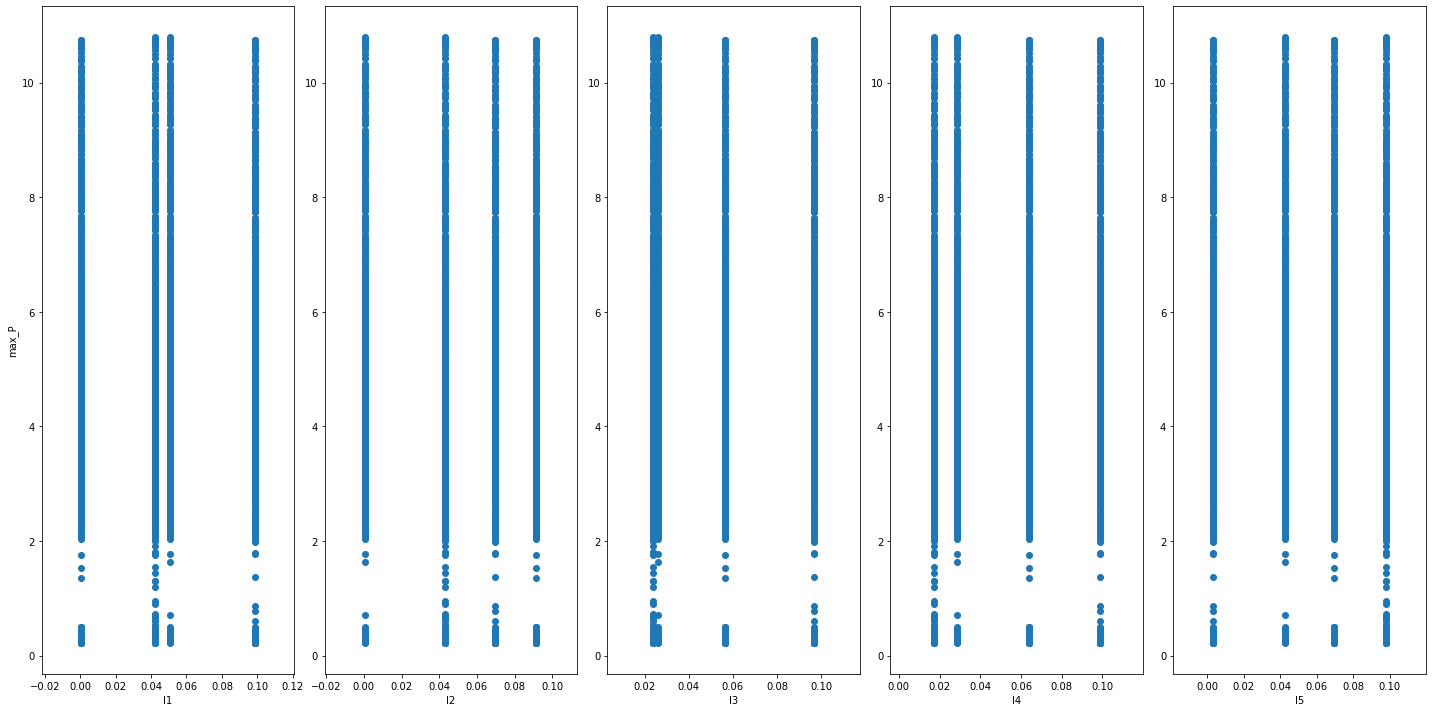

In [14]:
X2 = outcomes2['max_P']
#maxX = np.max(X, axis=1)

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 10))
axes[0].scatter(experiments2['l0'], X2)
axes[1].scatter(experiments2['l1'], X2)
axes[2].scatter(experiments2['l2'], X2)
axes[3].scatter(experiments2['l3'], X2)
axes[4].scatter(experiments2['l4'], X2)
axes[0].set_xlabel('l1')
axes[1].set_xlabel('l2')
axes[2].set_xlabel('l3')
axes[3].set_xlabel('l4')
axes[4].set_xlabel('l5')
axes[0].set_ylabel('max_P')
fig.tight_layout()

plt.show()

### Release decision's influence to Utility

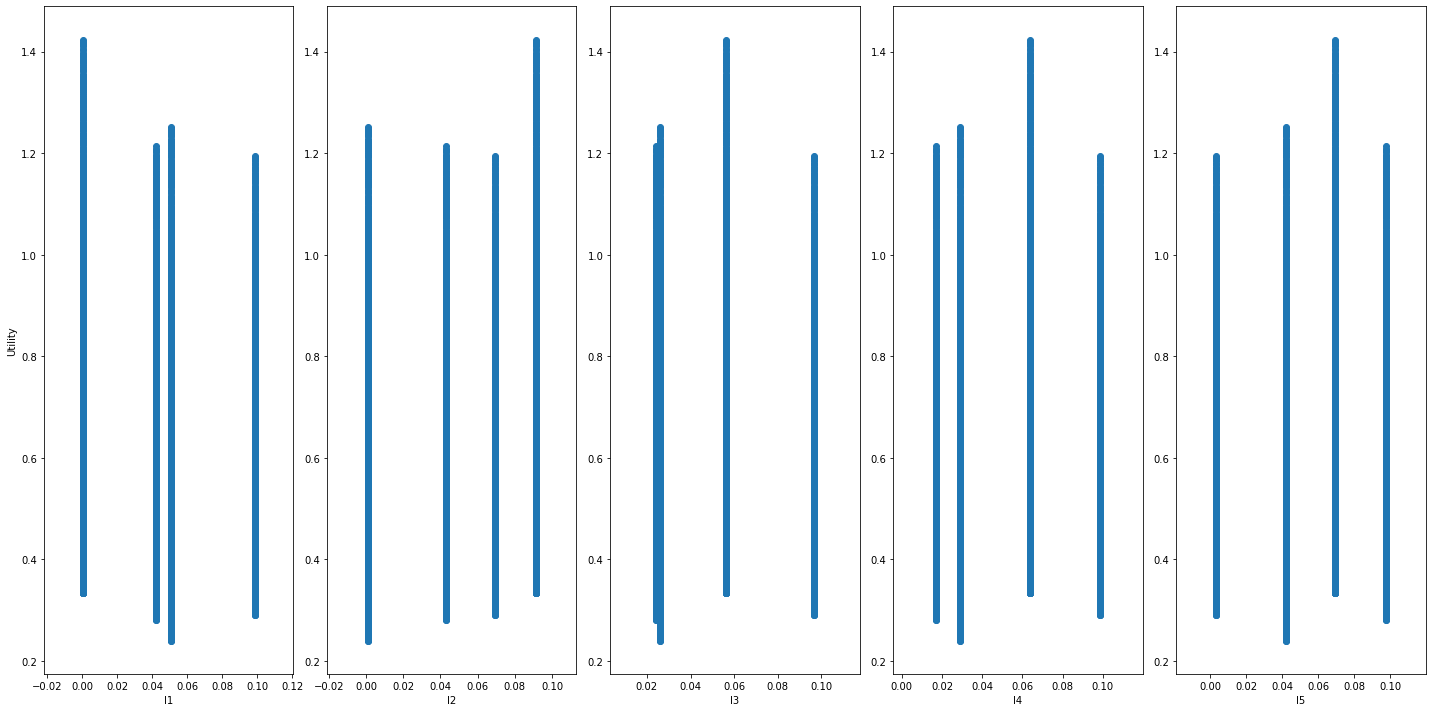

In [15]:
Utility2 = outcomes2['utility']
#maxX = np.max(X, axis=1)

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 10))
axes[0].scatter(experiments2['l0'], Utility2)
axes[1].scatter(experiments2['l1'], Utility2)
axes[2].scatter(experiments2['l2'], Utility2)
axes[3].scatter(experiments2['l3'], Utility2)
axes[4].scatter(experiments2['l4'], Utility2)
axes[0].set_xlabel('l1')
axes[1].set_xlabel('l2')
axes[2].set_xlabel('l3')
axes[3].set_xlabel('l4')
axes[4].set_xlabel('l5')
axes[0].set_ylabel('Utility')
fig.tight_layout()

plt.show()

### Release decision's influence to Inertia

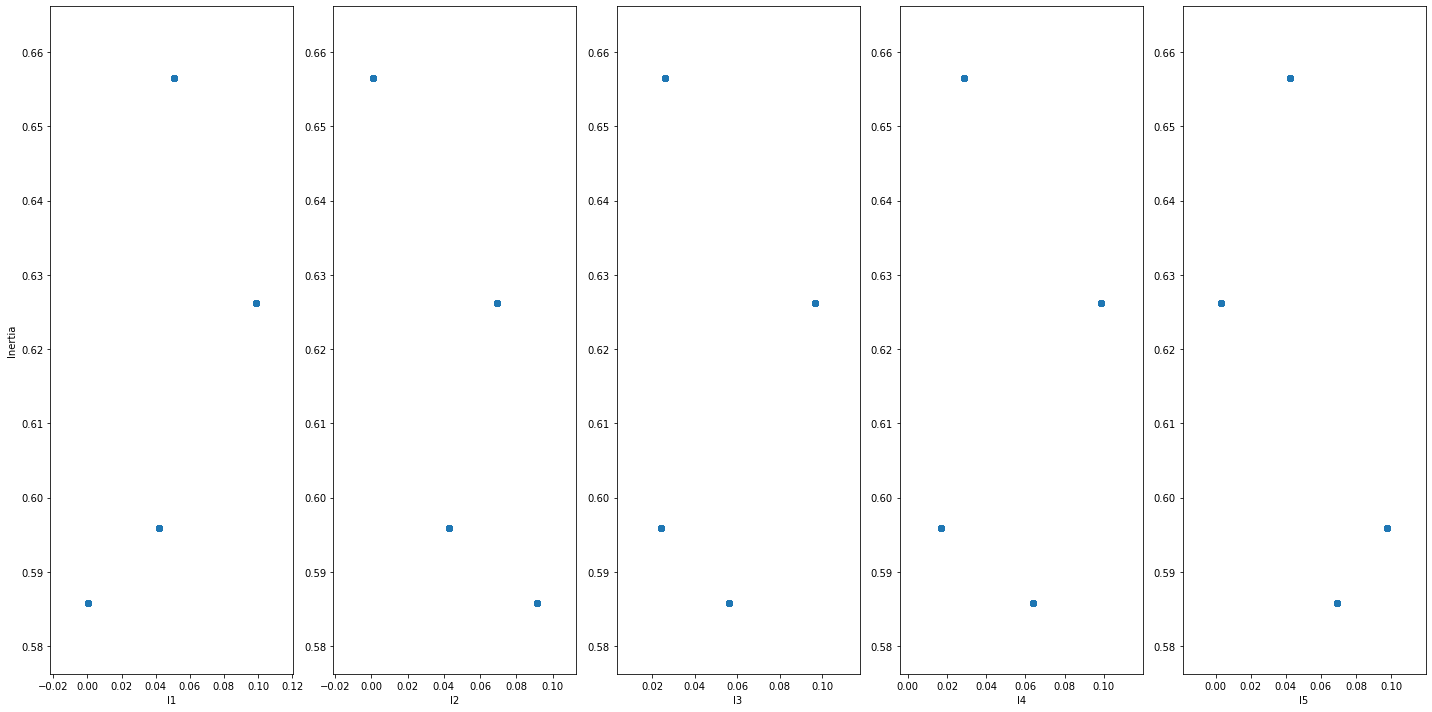

In [16]:
Inertia2 = outcomes2['inertia']
#maxX = np.max(X, axis=1)

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 10))
axes[0].scatter(experiments2['l0'], Inertia2)
axes[1].scatter(experiments2['l1'], Inertia2)
axes[2].scatter(experiments2['l2'], Inertia2)
axes[3].scatter(experiments2['l3'], Inertia2)
axes[4].scatter(experiments2['l4'], Inertia2)
axes[0].set_xlabel('l1')
axes[1].set_xlabel('l2')
axes[2].set_xlabel('l3')
axes[3].set_xlabel('l4')
axes[4].set_xlabel('l5')
axes[0].set_ylabel('Inertia')
fig.tight_layout()

plt.show()

### Release decision's influence to Reliability

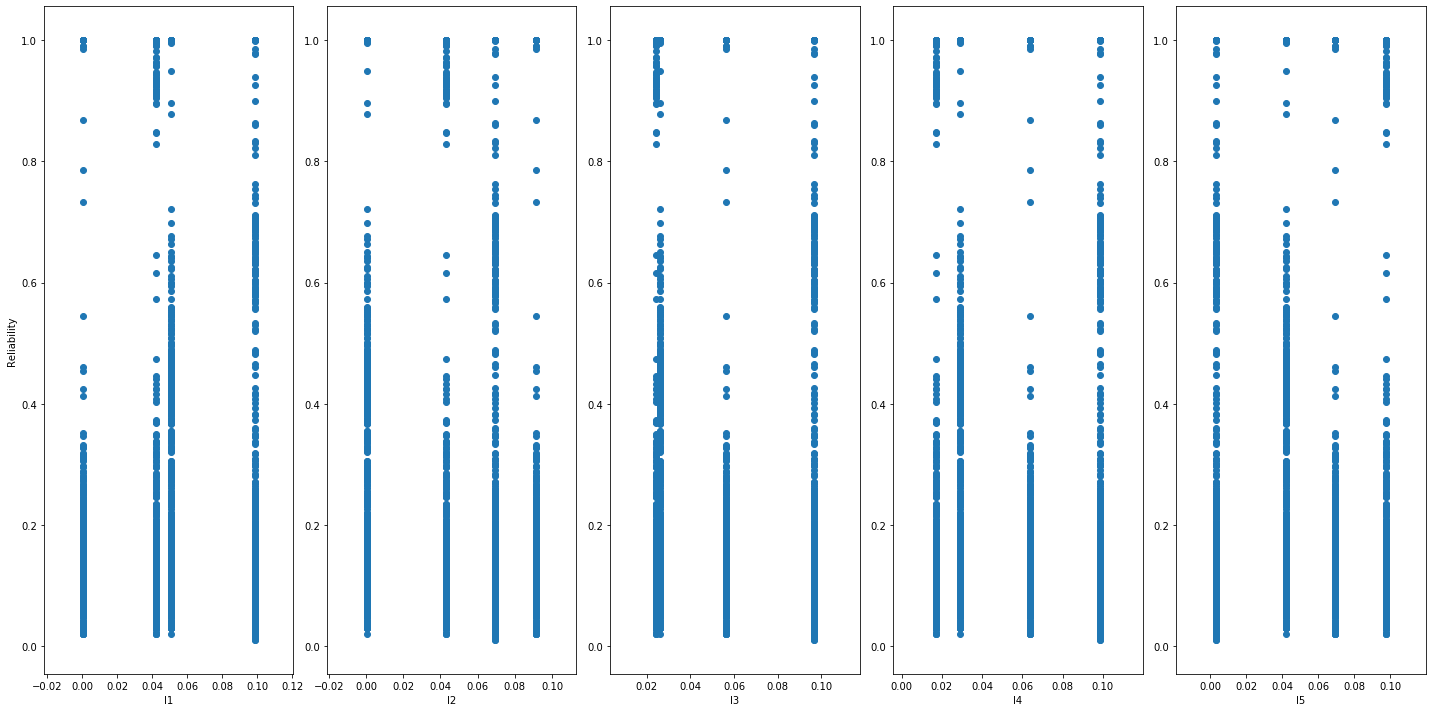

In [17]:
R2 = outcomes2['reliability']
#maxX = np.max(X, axis=1)
#ax = sns.boxplot(x="day", y="total_bill", data=tips)

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 10
                                                   ))
axes[0].scatter(experiments2['l0'], R2)
axes[1].scatter(experiments2['l1'], R2)
axes[2].scatter(experiments2['l2'], R2)
axes[3].scatter(experiments2['l3'], R2)
axes[4].scatter(experiments2['l4'], R2)
axes[0].set_xlabel('l1')
axes[1].set_xlabel('l2')
axes[2].set_xlabel('l3')
axes[3].set_xlabel('l4')
axes[4].set_xlabel('l5')
axes[0].set_ylabel('Reliability')
fig.tight_layout()

plt.show()

4. If you have not used parallelization in the foregoing, try to adapt your code to use parallelization. The workbench comes with two evaluators for parallelization. The `MultiProcessingingEvaluator` and the `IpyparallelEvaluator`. When can you use each? Adapt your code from above and sue the `MultiProcessingingEvaluator`. Use the time library to check how much faster the computation for 1000 scenarios completes. 

Using multiprocessing within a jupyter notebook is tricky. On linux it will work in general just fine. On mac it depends on the version of Mac OS and the version of Python. If you are on the latest version of Mac OS in combination with Python 3.8, it might work but no guarantees. On older versions of Python it should work fine. On Windows it is always a problem. 

The underlying explanation is quite technical. It has to do with how your operating system creates the additional python processes. On windows, and the latest version of Mac OS in combination with Python 3.8. A completely new Python process is spawned. This new process does **not** inherit what is defined in memory of the parent process. The new child process will try to replicate what is in memory of the parent process by executing many of the import statements that have also been executed within the python process. Thus, if you define a model in the main process, it is not guaranteed to be known in the child processes. This is in particular true if you define the model within a jupyter notebook. Then the child processes will **never** know this function. Within jupyter notebooks, therefore, the best practice is to define your model within a .py file and import this .py file into the notebook. Now, each of the child processes will also execute this import statement and thus know the function. 


In [18]:
start_time = time.perf_counter()
with MultiprocessingEvaluator(model) as evaluator:
    results = perform_experiments(model, 1000, evaluator=evaluator)
#experiments3, outcomes3 = evaluator.perform_experiments(scenarios=1000, policies=1)

print("--- %s seconds ---" % (time.perf_counter() - start_time))

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 1000 scenarios * 1 policies * 1 model(s) = 1000 experiments
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


--- 60.53321540000002 seconds ---


In [20]:
client= ipp.Client()
client.ids

[0, 1, 2, 3]

In [23]:
direct_view = client[:]
#Push the current working directory of the notebook to a "cwd" variable on the engines that can be accessed later
direct_view.push(dict(cwd=os.getcwd()))

#Push the "problem" variable from the notebook to a corresponding variable on the engines
direct_view.push(dict(problem=model))

<AsyncResult: _push>

In [26]:
start_time = time.perf_counter()
with IpyparallelEvaluator(model, client) as evaluator:
    results = perform_experiments(model, 1000)
#experiments3, outcomes3 = evaluator.perform_experiments(scenarios=1000, policies=1)

print("--- %s seconds ---" % (time.perf_counter() - start_time))

RemoteError: ModuleNotFoundError(No module named 'lake_problem_nesya')